# W-14

In [1]:
from FMM_BEM import read_geo_and_create_quadtree, assem_FMM, eval_sol, surf_plot
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib widget

In [3]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu, quadtree, boundary_points = read_geo_and_create_quadtree("files\disk.msh",[0, 1], [2, 3],max_points_quad=1,max_depth=20)

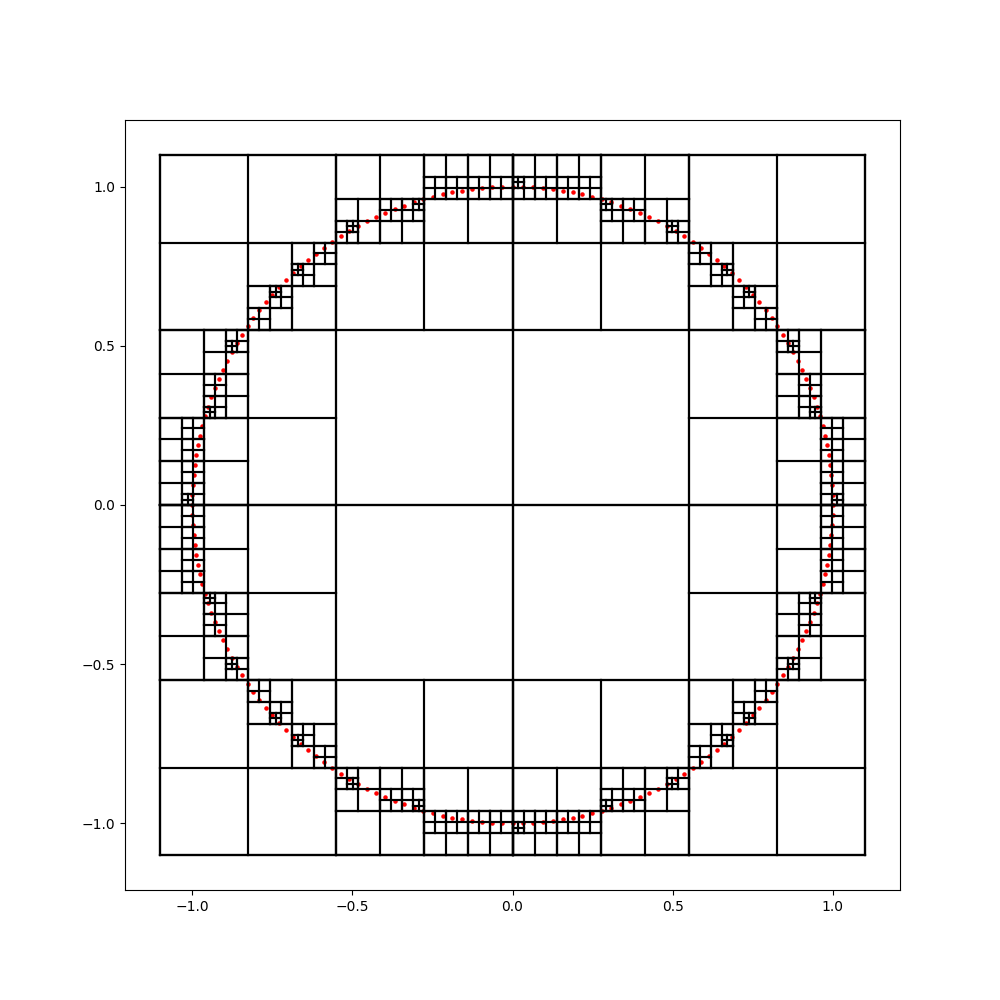

In [18]:
def plot_quadtree(node, ax):
    """ Función recursiva para dibujar los límites del quadtree. """
    xmin, ymin, xmax, ymax = node.bounds
    ax.plot([xmin, xmax], [ymin, ymin], 'k-')
    ax.plot([xmin, xmax], [ymax, ymax], 'k-')
    ax.plot([xmin, xmin], [ymin, ymax], 'k-')
    ax.plot([xmax, xmax], [ymin, ymax], 'k-')

    for child in node.children:
        plot_quadtree(child, ax)

# Visualizar el quadtree
fig, ax = plt.subplots(figsize=(10,10))
plot_quadtree(quadtree, ax)
ax.scatter(boundary_points[:, 0], boundary_points[:, 1], color='red', s=5)  # Dibujar los puntos de la frontera
plt.show()
plt.savefig("Quadtree_example.png")

In [5]:
Gmat, Fmat = assem_FMM(coords,elems,quadtree, order=10)


In [6]:
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve

def influence_coeff(elem, coords, pt_col):
    """Compute influence coefficients

    Parameters
    ----------
    elems : ndarray, int
        Connectivity for the elements.
    coords : ndarray, float
        Coordinates for the nodes.
    pt_col : ndarray
        Coordinates of the colocation point.

    Returns
    -------
    G_coeff : float
        Influence coefficient for flows.
    H_coeff : float
        Influence coefficient for primary variable.
    """
    dcos = coords[elem[1]] - coords[elem[0]]
    dcos = dcos / norm(dcos)
    rotmat = np.array([[dcos[1], -dcos[0]],
                       [dcos[0], dcos[1]]])
    r_A = rotmat.dot(coords[elem[0]] - pt_col)
    r_B = rotmat.dot(coords[elem[1]] - pt_col)
    theta_A = arctan2(r_A[1], r_A[0])
    theta_B = arctan2(r_B[1], r_B[0])
    if norm(r_A) <= 1e-6:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0]
    elif norm(r_B) <= 1e-6:
        G_coeff = -(r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    else:
        G_coeff = r_B[1]*(log(norm(r_B)) - 1) + theta_B*r_B[0] -\
                  (r_A[1]*(log(norm(r_A)) - 1) + theta_A*r_A[0])
    H_coeff = theta_B - theta_A
    return -G_coeff/(2*pi), H_coeff/(2*pi)

def assem(coords, elems):
    """Assembly matrices for the BEM problem

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.

    Returns
    -------
    Gmat : ndarray, float
        Influence matrix for the flow.
    Hmat : ndarray, float
        Influence matrix for primary variable.
    """
    nelems = elems.shape[0]
    Gmat = np.zeros((nelems, nelems))
    Hmat = np.zeros((nelems, nelems))
    for ev_cont, elem1 in enumerate(elems):
        for col_cont, elem2 in enumerate(elems):
            pt_col = mean(coords[elem2], axis=0)
            if ev_cont == col_cont:
                L = norm(coords[elem1[1]] - coords[elem1[0]])
                Gmat[ev_cont, ev_cont] = - L/(2*pi)*(log(L/2) - 1)
                Hmat[ev_cont, ev_cont] = - 0.5
            else:
                Gij, Hij = influence_coeff(elem1, coords, pt_col)
                Gmat[ev_cont, col_cont] = Gij
                Hmat[ev_cont, col_cont] = Hij
    return Gmat, Hmat

In [7]:
Gclassic, Fclassic = assem(coords, elems)

In [8]:
# Comparación de resultados
print("Diferencias en la matriz G:")
print(np.abs(Gclassic - Gmat))

print("\nDiferencias en la matriz H:")
print(np.abs(Fclassic - Fmat))

Diferencias en la matriz G:
[[0.         0.14158431 0.14516288 ... 0.14700212 0.14507495 5.04936425]
 [0.14158486 0.         5.04936424 ... 0.14851525 0.14720944 0.14515777]
 [0.14515817 5.04936424 0.         ... 0.14986733 0.14850364 0.14703639]
 ...
 [0.14746953 0.14850364 0.14986733 ... 0.         5.04936426 0.14532853]
 [0.14537612 0.14720944 0.14851525 ... 5.04936426 0.         5.04936426]
 [5.04936425 0.14515794 0.14704535 ... 0.14499382 5.04936426 0.        ]]

Diferencias en la matriz H:
[[0.00000000e+00 3.39832763e-03 2.40536937e-03 ... 2.83331329e-03
  2.59303149e-03 1.61314068e+02]
 [3.39494271e-03 0.00000000e+00 1.61314067e+02 ... 3.20106114e-03
  2.55940064e-03 2.67484322e-03]
 [2.39343819e-03 1.61314067e+02 0.00000000e+00 ... 2.49129449e-03
  1.83540184e-03 2.08905502e-03]
 ...
 [2.97735099e-03 3.24406932e-03 2.55931554e-03 ... 0.00000000e+00
  1.61314069e+02 3.13204246e-03]
 [2.55473154e-03 2.58356498e-03 1.87841003e-03 ... 1.61314069e+02
  0.00000000e+00 1.61314069e+02]

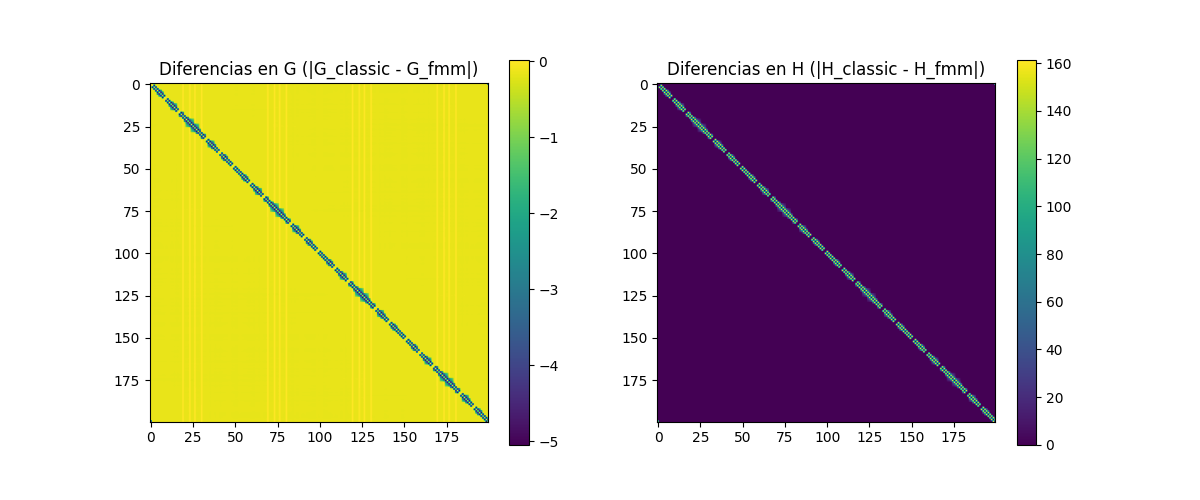

In [9]:
# Visualización de diferencias
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(Gclassic - Gmat, cmap='viridis')
plt.colorbar()
plt.title("Diferencias en G (|G_classic - G_fmm|)")

plt.subplot(1, 2, 2)
plt.imshow(Fclassic - Fmat, cmap='viridis')
plt.colorbar()
plt.title("Diferencias en H (|H_classic - H_fmm|)")
plt.show()

In [10]:
A = np.zeros_like(Fmat)
B = np.zeros_like(Fmat)

In [11]:
A[np.ix_(id_dir, id_dir)] = Gmat[np.ix_(id_dir, id_dir)]
A[np.ix_(id_dir, id_neu)] = -Fmat[np.ix_(id_dir, id_neu)]
A[np.ix_(id_neu, id_dir)] = Gmat[np.ix_(id_neu, id_dir)]
A[np.ix_(id_neu, id_neu)] = -Fmat[np.ix_(id_neu, id_neu)]


In [12]:
B[np.ix_(id_dir, id_dir)] = Fmat[np.ix_(id_dir, id_dir)]
B[np.ix_(id_dir, id_neu)] = -Gmat[np.ix_(id_dir, id_neu)]
B[np.ix_(id_neu, id_dir)] = Fmat[np.ix_(id_neu, id_dir)]
B[np.ix_(id_neu, id_neu)] = -Gmat[np.ix_(id_neu, id_neu)]

In [13]:
theta = np.unwrap(np.arctan2(y_m, x_m))
rhs = np.zeros(elems.shape[0])
rhs[id_dir] = 3*np.cos(6*theta[id_dir])
rhs[id_neu] = -18*np.cos(6*theta[id_neu])


In [14]:
from scipy.sparse.linalg import gmres, LinearOperator

# Define el vector inicial
rhs_modified = B.dot(rhs)


# Define la función matvec_A como antes
def matvec_A(x):
    result = np.zeros_like(x)
    result[np.ix_(id_dir)] = Gmat[np.ix_(id_dir)].dot(x) - Fmat[np.ix_(id_dir)].dot(x)
    result[np.ix_(id_neu)] = Gmat[np.ix_(id_neu)].dot(x) - Fmat[np.ix_(id_neu)].dot(x)
    return result

# Define las dimensiones del sistema (deben coincidir con el tamaño de rhs y de A)
shape = (rhs_modified.size, rhs_modified.size)

# Crea el LinearOperator a partir de matvec_A
A_operator = LinearOperator(shape, matvec=matvec_A)

# Usa gmres para resolver el sistema
sol,_ = gmres(A_operator, rhs_modified)

In [15]:
u_bound = np.zeros_like(sol)
q_bound = np.zeros_like(sol)
u_bound[id_dir] = rhs[id_dir]
u_bound[id_neu] = sol[id_neu]
q_bound[id_dir] = sol[id_dir]
q_bound[id_neu] = rhs[id_neu]

In [16]:
solution_1 = eval_sol(mesh.points[:, :2], coords, elems, u_bound, q_bound)

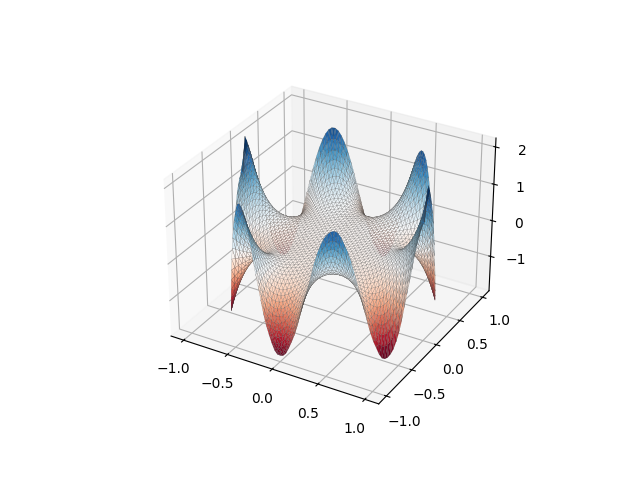

In [17]:
ax = surf_plot(mesh, 4, solution_1)
